In [1]:
#https://github.com/Kulbear/stock-prediction/blob/master/stock-prediction.ipynb
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

Using TensorFlow backend.


In [2]:
def build_model(layers, act = 'linear', D1 = 0.25, D2 = 0.25):
    model = Sequential()

    #First LSTM Layer
    model.add(LSTM(
        units=layers[1],
        input_shape=(layers[1],layers[0]),
        return_sequences = True))
    model.add(Dropout(D1))

    #Second LSTM Layer
    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(D2))

    #Final Dense Layer
    model.add(Dense(
        units = layers[3]))
    model.add(Activation(act))

    start = time.clock()
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    print('Compilation Time : ', time.clock() - start)
    return model

def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

def preprocess_data(stock, sequence_length, percent_train = 0.9):
    num_features = stock.shape[1]
    sequence_length += 1
    
    #TODO
    #Rewrite this to use arrays from the beginning, it will speed up the computation
    result = []
    #Create list of windows
    for index in range(len(stock) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    #Use certain percentage of the data for training
    row = round(percent_train * result.shape[0])
    train = result[:int(row),:]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:,:-1]
    y_train = train[:,-1][:,-1]
    X_test = result[int(row):,:-1]
    y_test = result[int(row):,-1][:,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))  

    return [X_train, y_train, X_test, y_test]

In [3]:
data = np.loadtxt('DailyStocks.dat')
#data = np.hstack((data,np.real(np.fft.fft(data)),np.imag(np.fft.fft(data))))

In [13]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(data, window)
print "X_train:", X_train.shape
print "y_train:", y_train.shape
print "X_test:", X_test.shape
print "y_test:", y_test.shape

X_train: (881, 20, 4)
y_train: (881,)
X_test: (98, 20, 4)
y_test: (98,)


In [5]:
num_neurons = 128
out_dim = 1
model = build_model([X_train.shape[2], window, num_neurons, out_dim], D1 = 0.1, D2 = 0.1)

('Compilation Time : ', 0.05446799999999996)


In [6]:
start = time.clock()
model.fit(
    X_train,
    y_train,
    batch_size=100,
    epochs=25,
    validation_split=0.1,
    verbose=0)
print time.clock() - start

74.656193


In [7]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.4f MSE (%.4f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.0195 MSE (0.1396 RMSE)
Test Score: 0.0169 MSE (0.1299 RMSE)


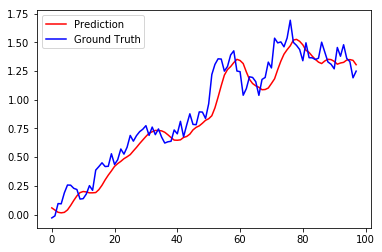

In [10]:
import matplotlib.pyplot as plt

plt.plot(model.predict(X_test), color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()

In [9]:
plt.plot(clean[:,0])
plt.show()

NameError: name 'clean' is not defined

In [ ]:
print X_train.shape[2]

In [11]:
clean = np.hstack((data, np.real(np.fft.fft(data, axis=0)), np.imag(np.fft.fft(data, axis=0))))
clean = (clean - clean.mean(axis=0)) / clean.std(axis=0)
print clean.mean(axis=0)
print clean.std(axis=0)
print clean.shape
print clean

[ -2.15361062e-15   5.92659255e-15  -3.05222514e-15  -1.45106149e-15
   3.33066907e-17  -2.35367281e-17   2.70894418e-17  -1.44328993e-16
   0.00000000e+00   0.00000000e+00  -4.26325641e-17   7.10542736e-18]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
(1000, 12)
[[  2.09873599e+00   2.05140917e+00   2.05177373e+00 ...,  -4.06588749e-18
    2.02196408e-18  -2.87061222e-17]
 [  2.12629443e+00   2.21370101e+00   2.19630432e+00 ...,   1.70810770e+01
    1.70738843e+01   1.70740322e+01]
 [  2.21971122e+00   2.29248657e+00   2.28122531e+00 ...,  -1.01598559e+01
   -1.01568250e+01  -1.01715800e+01]
 ..., 
 [  1.07312906e+00   9.86941358e-01   1.05004899e+00 ...,   8.33944576e+00
    8.36266815e+00   8.35885956e+00]
 [  1.09947631e+00   1.07175449e+00   1.06825163e+00 ...,   1.01598559e+01
    1.01568250e+01   1.01715800e+01]
 [  1.14546674e+00   1.17254774e+00   1.14690218e+00 ...,  -1.70810770e+01
   -1.70738843e+01  -1.70740322e+01]]


In [ ]:
np.savetxt('test.dat', np.fft.fft(data, axis=0), delimiter=',')

In [ ]:
plt.plot(clean[:,-1])
plt.show()